In [26]:
import torch
import numpy as np
import sys
import matplotlib.pyplot as plt 
from torch.func import vmap, grad
from tqdm import tqdm
sys.path.append("..\\")
plt.style.use("dark_background")
device = "cuda"

In [27]:
weights_prior = torch.load("../weights_1000ep.pt")
from model import ScoreNetwork0
score_prior = ScoreNetwork0().to(device)
score_prior.load_state_dict(weights_prior)

<All keys matched successfully>

We just apply a mask after taking the FFT of the image for now. 
Our physical model A is: 
$$
A = S(u,v)\mathcal{F}(\mathbf{x})
$$
where $S(u, v)$ is basically a sampling function taking account of the fact that we only have measurements of the visibility at specific uv points and not in the whole uv space. 

However, our full model is 
$$ 
\mathbf{y} = A\mathbf{x} + \eta 
$$

where, for now, we take our noise model to be simply gaussian, so $\eta \sim \mathcal{N}(0, \mathbf{I})$

We code that by taking the FFT of the $\mathbf{x}$ and that applying a mask to it (meaning that we lose some information) (the mask gets rid of the information)


Text(0.5, 1.0, 'Inverse FFT')

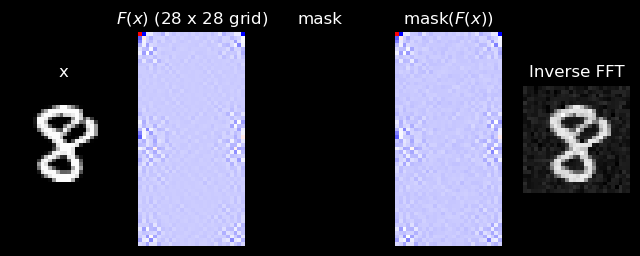

In [30]:
dataset = torch.load("../../MNIST_torch/test_images.pt")
k = torch.randint(len(dataset), size = (1,))
img = dataset[k].reshape(28, 28).to(device)
img_size = img.shape[-1]

p = 1
mask = torch.bernoulli(p * torch.ones(img_size ** 2)).type(torch.bool)
mask = torch.cat([mask, mask], dim = 0).to(device)
obs_dim = mask.sum()

sigma_likelihood = 0.05
dist_likelihood = torch.distributions.MultivariateNormal(loc = torch.zeros(2 * img_size ** 2, device = device), covariance_matrix = sigma_likelihood**2 * torch.eye(2 *img_size**2, device = device), validate_args=False) 
z = dist_likelihood.sample([]).to(device)

y_1 = torch.fft.fft2(img, norm = "ortho").flatten()
y = torch.cat([y_1.real, y_1.imag])[mask] + z[mask]
fig, axs = plt.subplots(1, 5, figsize = (8, 4))

for i in range(len(axs)): 
    axs[i].axis("off")

axs[0].imshow(img.cpu(), cmap = "gray")
axs[0].axis("off")
axs[0].set_title("x")


y_rep = torch.cat([y_1.real, y_1.imag])
axs[1].imshow((y_rep).reshape(-1,28).real.cpu(), cmap = "bwr")
axs[1].axis("off")
axs[1].set_title(r"$F(x)$ (28 x 28 grid)")

axs[2].imshow(mask.cpu().reshape(-1, 28), cmap = "gray")
axs[2].set_title("mask")

axs[3].imshow((y_rep * mask + z * mask).reshape(-1,28).real.cpu(), cmap = "bwr")
axs[3].set_title(r"mask$(F(x))$")

x_rec = y_rep * mask +  z * mask
x_rec = torch.fft.ifft2((x_rec[:img_size**2,] + 1j * x_rec[img_size ** 2:]).reshape(img_size, img_size))

axs[4].imshow(x_rec.real.cpu(), cmap = "gray")
axs[4].set_title("Inverse FFT")

In [31]:
y_rep

tensor([ 4.9958, -3.3089,  0.4573,  ..., -0.0757, -0.3677,  0.1738],
       device='cuda:0')

At temperature $t$, $\mathbf{x}_t = \boldsymbol{\mu}(t) + \sigma(t)\mathbf{z}$ where $\mathbf{z}\sim \mathcal{N}(0,\mathbf{I})$. 
We can rewrite in approximation : 
$$
\mathbf{y} - A\boldsymbol{\mu}(t) = \boldsymbol{\eta} + A\sigma(t)\mathbf{z} \sim p_t(\mathbf{y}|\mathbf{x}) \approx p_t(\mathbf{y}-A\boldsymbol{\mu}(t)) = p_t(\boldsymbol{\eta}) \circledast p(A\sigma(t)\mathbf{z}) = \mathcal{N}(0, (\sigma_y^2+ \sigma(t)^2) \mathbf{I} )
$$
where $\sigma^2(t) = 1-\exp\left(-\int_0^t \beta(s) ds\right)$ and $\mu(t) = \mathbf{x_0}\exp\left(-0.5\int_0^t \beta(s) ds\right)$

In [32]:
def beta(t): 
    return 0.1 + (20-0.1) * t
def int_beta(t): 
    return 0.1 * t + (20 - 0.1) * t **2 / 2
 
def sigma(t): 
    return torch.sqrt(1-torch.exp(-int_beta(t)))

def logprob_likelihood(x, cov_mat): 
    dist = torch.distributions.MultivariateNormal(loc = torch.zeros(obs_dim, device = x.device), covariance_matrix = cov_mat, validate_args=False)
    return dist.log_prob(x)

def f(x): 
    ft = torch.fft.fft2(x.reshape(img_size, img_size), norm = "ortho").flatten()
    ft_rep = torch.cat([ft.real, ft.imag])
    return ft_rep

def score_likelihood(x, t): 
    return vmap(grad(lambda x, t: logprob_likelihood(y- f(x)[mask],  (sigma_likelihood ** 2 + sigma(t)**2) * torch.eye(obs_dim, device = x.device))))(x, t)

#torch.manual_seed(0)
def score_posterior(x, t): 
    return score_prior(x, t) + score_likelihood(x, t)

x = torch.randn([10, 784]).to(device) 
t = torch.ones(10).to(device)

print((torch.sum(score_likelihood(x, t)**2))**0.5)
print(score_likelihood(x, t))

tensor(95.1431, device='cuda:0')
tensor([[ 0.9428,  0.0257,  1.0881,  ...,  0.0355, -0.1491,  0.6440],
        [ 0.5498,  0.0948, -0.8005,  ...,  0.1302, -0.4347,  0.8475],
        [ 0.2294, -1.8008, -2.1107,  ...,  0.8751, -1.3615, -0.1605],
        ...,
        [ 0.3498,  2.2641,  1.1976,  ..., -1.6882, -1.7999, -0.2195],
        [-0.5446,  0.5755,  0.8958,  ...,  0.4917, -0.1804, -1.0824],
        [ 0.6739,  1.4497, -0.2448,  ...,  0.9735,  1.4793, -0.3097]],
       device='cuda:0')


In [33]:
x = torch.randn([10, 784]).to(device) 
t = torch.ones(10).to(device)

score_likelihood(x, 0 * t)

tensor([[ 138.1049,   81.3228, -312.4065,  ..., -307.1937,  494.5598,
          445.8363],
        [ 146.2683,   57.1868,   68.9652,  ..., -250.2428,  310.2950,
          -70.9577],
        [ 149.0088, -436.8120,   99.1765,  ...,  405.0491,   41.6842,
         -134.5967],
        ...,
        [-172.1220, -214.4707,  468.1756,  ...,  512.2155, -227.3960,
          404.9499],
        [ 889.3311,   83.0654, -106.4309,  ...,  225.0026,  -91.6074,
           64.2854],
        [ 665.0399, -481.7171, -164.8546,  ...,  569.5631,  605.4794,
          873.9291]], device='cuda:0')

In [15]:
def pc_sampler(num_samples, num_pred_steps, num_corr_steps, score_function, snr = 1e-2, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_pred_steps
    with torch.no_grad(): 
        for _ in tqdm(range(num_pred_steps-1)): 
            # Corrector step: (Only if we are not at 0 temperature )
            gradient = score_function(x, t)
            for _ in range(num_corr_steps): 
                z = torch.randn_like(x)
                grad_norm = torch.mean(torch.norm(gradient, dim = -1)) # mean of the norm of the score over the batch 
                noise_norm = torch.mean(torch.norm(z, dim = -1))
                epsilon =  2 * (snr * noise_norm / grad_norm) ** 2
                x = x + epsilon * gradient + (2 * epsilon) ** 0.5 * z * dt  

        
            # Predictor step: 
            z = torch.randn_like(x)
            x_mean  = x + (-0.5 * beta(t) * x - beta(t) * gradient) * dt 
            noise = (beta(t) * -dt) ** 0.5 * z 
            x = x_mean + noise
            t += dt
    return x_mean

def euler_sampler(num_samples, num_steps, score_function, img_size = 28): 
    t = torch.ones(size = (num_samples, 1)).to(device)
    x = torch.randn([num_samples, img_size ** 2]).to(device)
    dt = -1/num_steps
    with torch.no_grad(): 
        for i in tqdm(range(num_steps - 1)): 
            z = torch.randn_like(x).to(device)
            gradient = score_function(x, t)
            x_mean = x + (-0.5 * beta(t) * x - beta(t) * gradient) * dt
            noise = (beta(t) * -dt) ** 0.5 * z
            x = x_mean + noise
            t += dt
            
            if i in [470, 480, 495, 496, 497, 498, 499]: 
                print(x_mean[0, 0], gradient, noise) 

    return x_mean


#pc_samples = pc_sampler(num_samples = 100, num_pred_steps = 500, num_corr_steps = 20, snr = 1e-2, score_function = score_posterior, img_size = 28)
euler_samples = euler_sampler(num_samples = 100, num_steps = 500, score_function = score_posterior, img_size = 28)


  5%|▍         | 24/499 [00:10<03:33,  2.23it/s]


KeyboardInterrupt: 

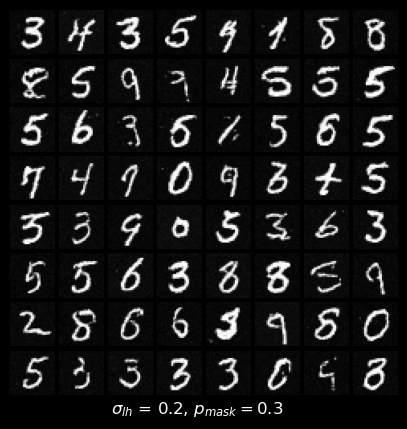

In [ ]:
def plot_samples(samples, nrows, ncols): 
    plt.style.use("dark_background")
    if samples.shape[0]< nrows * ncols: 
        raise ValueError("Not enough samples for the number of rows and cols specified")
    fig, axs = plt.subplots(nrows, ncols, figsize=(5, 5))
    k = 0
    for i in range(nrows):
        for j in range(ncols):
            axs[i, j].imshow(samples[k].reshape(28, 28).detach().cpu().numpy(), cmap="gray")
            axs[i, j].axis("off")
            k+=1
    plt.suptitle(r"$\sigma_{lh}$ = " + f"{sigma_likelihood}, " + r"$p_{mask} = $" + f"{p}", y = 0.1)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    

plot_samples(euler_samples, nrows = 8, ncols = 8)

Just need to apply the FFT to the given gridded data for the real project, but for the example, we need to have a way to grid the uv coverage and to have the visibilities

In [3]:
uv_coverage = torch.empty(size = (500, 2)).uniform_(-7, 7)

In [26]:
fov = 14
pixel_scale = 0.5
num_cells = int(14//0.5)